In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL
import shutil
import zipfile
import glob
import os
import time

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
currentPath = os.getcwd()
print(currentPath)

C:\Users\thdal\PycharmProjects\pythonProject


In [5]:
data_zip_dir = 'C:\\Users\\thdal\\PycharmProjects\\pythonProject\\input'
train_zip_dir = os.path.join(data_zip_dir, 'train.zip')
test_zip_dir = os.path.join(data_zip_dir, 'test.zip')

with zipfile.ZipFile(train_zip_dir, 'r') as z:
    z.extractall()
with zipfile.ZipFile(test_zip_dir, 'r') as z:
    z.extractall()

In [6]:
train_dir = 'C:\\Users\\thdal\\PycharmProjects\\pythonProject\\train'
test_dir = 'C:\\Users\\thdal\\PycharmProjects\\pythonProject\\test'

train_set_dir = os.path.join(train_dir, 'train')
os.mkdir(train_set_dir)
valid_set_dir = os.path.join(train_dir, 'valid')
os.mkdir(valid_set_dir)
test_set_dir = os.path.join(train_dir, 'test')
os.mkdir(test_set_dir)

dog_files = [f'dog.{i}.jpg' for i in range(12500)]
cat_files = [f'cat.{i}.jpg' for i in range(12500)]


In [7]:
for dog, cat in zip(dog_files[:10000], cat_files[:10000]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(train_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(train_set_dir, cat)
    shutil.move(src, dst)

for dog, cat in zip(dog_files[10000:11250], cat_files[10000:11250]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(valid_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(valid_set_dir, cat)
    shutil.move(src, dst)

for dog, cat in zip(dog_files[11250:12500], cat_files[11250:12500]):
    src = os.path.join(train_dir, dog)
    dst = os.path.join(test_set_dir, dog)
    shutil.move(src, dst)
    src = os.path.join(train_dir, cat)
    dst = os.path.join(test_set_dir, cat)
    shutil.move(src, dst)

In [8]:
print(f'the number of train set : {len(os.listdir(train_set_dir))}')
print(f'the number of validn set : {len(os.listdir(valid_set_dir))}')
print(f'the number of test set : {len(os.listdir(test_set_dir))}')

the number of train set : 20000
the number of validn set : 2500
the number of test set : 2500


In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform

        if 'cat' in files[0]:
            self.label = 0
        else:
            self.label = 1

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))

        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

In [10]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])

In [11]:
train_dog_dataset = CustomDataset(dog_files[:10000], train_set_dir, transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:10000], train_set_dir, transform=train_transform)
valid_dog_dataset = CustomDataset(dog_files[10000:11250], valid_set_dir, transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[10000:11250], valid_set_dir, transform=test_transform)
test_dog_dataset = CustomDataset(dog_files[11250:], test_set_dir, transform=test_transform)
test_cat_dataset = CustomDataset(cat_files[11250:], test_set_dir, transform=test_transform)

train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_dog_dataset, test_cat_dataset])

In [12]:
print(f'number of train dataset : {len(train_dataset)}')
print(f'number of valid dataset : {len(valid_dataset)}')
print(f'number of test dataset : {len(test_dataset)}')

number of train dataset : 20000
number of valid dataset : 2500
number of test dataset : 2500


In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [15]:
model = torchvision.models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.Dropout(0.1),
    nn.Linear(512, 1),
    nn.Sigmoid()
)
model.cuda()

C:\Users\thdal\anaconda3\envs\pythonProject\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\thdal\anaconda3\envs\pythonProject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
def result(model, criterion, optimizer, epochs, train_loader, valid_loader):
    model.train()

    train_loss = 0
    train_acc = 0
    train_correct = 0

    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(epochs):
        start = time.time()
        for train_x, train_y in train_loader:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).float()
            optimizer.zero_grad()
            pred = model(train_x)
            loss = criterion(pred, train_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            train_correct += y_pred.eq(train_y.cpu()).int().sum()

        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0
        for valid_x, valid_y in valid_loader:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).float()
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
            valid_loss += loss.item()

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()


        train_acc = train_correct/len(train_loader.dataset)
        valid_acc = valid_correct/len(valid_loader.dataset)

        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')

        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)

        train_loss = 0
        train_acc = 0
        train_correct = 0

    plt.plot(train_losses, label='loss')
    plt.plot(train_accuracies, label='accuracy')
    plt.legend()
    plt.title('train loss and accuracy')
    plt.show()

    plt.plot(valid_losses, label='loss')
    plt.plot(valid_accuracies, label='accuracy')
    plt.legend()
    plt.title('valid loss and accuracy')
    plt.show()

385.040sec : [Epoch 1/10] -> train loss: 0.0889, train acc: 97.660% / valid loss: 0.0238, valid acc: 99.200%
274.641sec : [Epoch 2/10] -> train loss: 0.0184, train acc: 99.385% / valid loss: 0.0190, valid acc: 99.320%
275.619sec : [Epoch 3/10] -> train loss: 0.0097, train acc: 99.685% / valid loss: 0.0230, valid acc: 99.360%
272.887sec : [Epoch 4/10] -> train loss: 0.0075, train acc: 99.745% / valid loss: 0.0250, valid acc: 99.440%
272.539sec : [Epoch 5/10] -> train loss: 0.0069, train acc: 99.770% / valid loss: 0.0314, valid acc: 99.080%
272.258sec : [Epoch 6/10] -> train loss: 0.0035, train acc: 99.900% / valid loss: 0.0690, valid acc: 99.040%
272.101sec : [Epoch 7/10] -> train loss: 0.0025, train acc: 99.945% / valid loss: 0.0724, valid acc: 99.160%
272.581sec : [Epoch 8/10] -> train loss: 0.0030, train acc: 99.890% / valid loss: 0.0796, valid acc: 99.000%
272.004sec : [Epoch 9/10] -> train loss: 0.0033, train acc: 99.880% / valid loss: 0.0682, valid acc: 99.320%
272.051sec : [Epoch

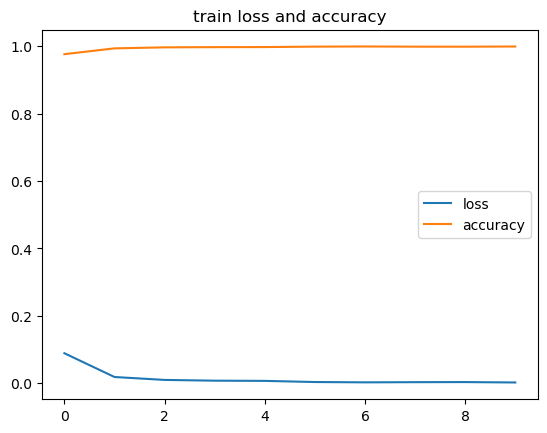

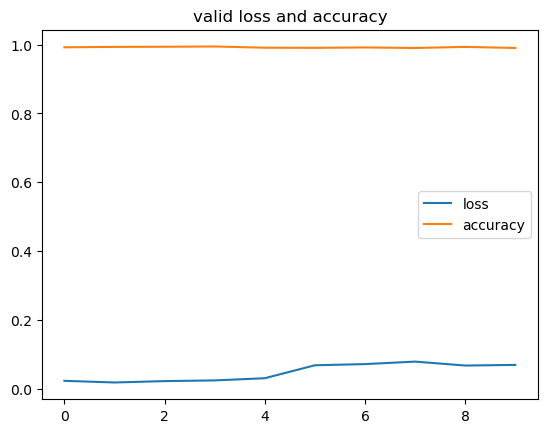

In [17]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

result(model, criterion, optimizer, 10, train_loader, valid_loader)

In [18]:
def eval(model, criterion, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        losses = 0
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device).float()
            pred = model(test_x)
            loss = criterion(pred, test_y)

            y_pred = pred.cpu()
            y_pred[y_pred >= 0.5] = 1
            y_pred[y_pred < 0.5] = 0

            losses += loss.item()
            correct += y_pred.eq(test_y.cpu()).int().sum()
    print(f'eval loss: {losses/len(test_loader):.4f}, eval acc: {correct/len(test_loader.dataset)*100:.3f}%')

In [19]:
eval(model, criterion, test_loader)

eval loss: 0.0367, eval acc: 99.160%


In [20]:
submit_files = [f'{i}.jpg' for i in range(1, 12500+1)]
submit_dataset = CustomDataset(submit_files, test_dir, mode='test', transform=test_transform)
submit_loader = torch.utils.data.DataLoader(submit_dataset, batch_size=32, shuffle=False)

In [21]:
def predict(model, data_loader):
    with torch.no_grad():
        model.eval()
        ret = None
        for img, files in data_loader:
            img = img.to(device)
            pred = model(img)

            if ret is None:
                ret = pred.cpu().numpy()
            else:
                ret = np.vstack([ret, pred.cpu().numpy()])
    return ret

pred = predict(model, submit_loader)

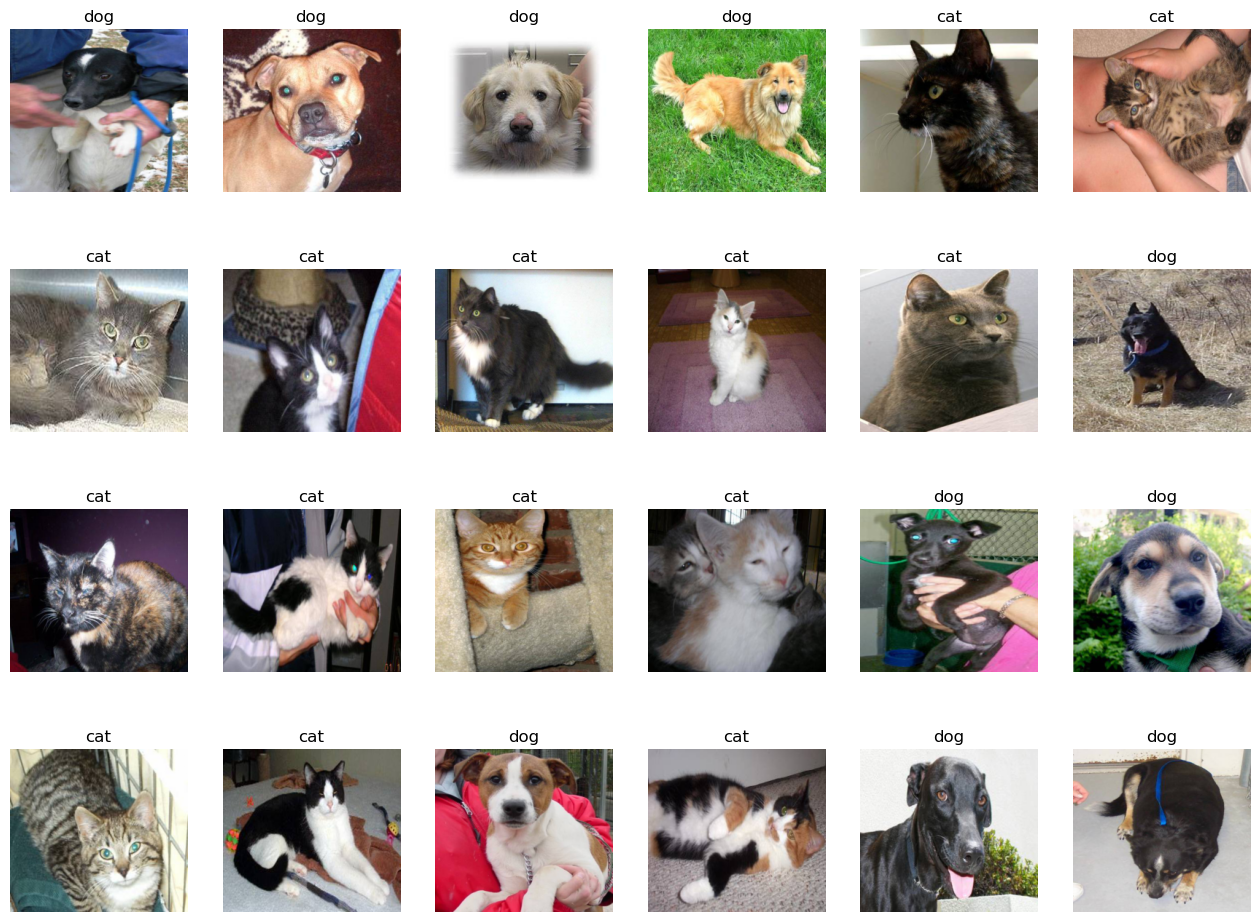

In [26]:
sample_pred = pred[:24]
sample_pred[sample_pred >= 0.5] = 1
sample_pred[sample_pred < 0.5] = 0

imgs, files = next(iter(submit_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[sample_pred[i][0]])
    a.axis('off')
    a.imshow(np.transpose(imgs[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)